In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [ ]:
! pip uninstall tensorflow==2.17.0

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.17.1


In [ ]:
!pip -q install tensorflow==2.8.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 47.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.10 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
google-cloud-aipl


# Model 1: Multivariate-3-RNN



In [ ]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
print(tf.__version__)


2.8.4


In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [ ]:
# Loading the dataset
url = 'vnindex.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)

In [ ]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2000-07-28,100.00,100.00,100.00,100.00,4200
2000-07-28,100.00,100.00,100.00,100.00,4200
2000-07-31,101.55,101.55,101.55,101.55,10300
2000-08-02,103.38,103.38,103.38,103.38,300
2000-08-04,105.20,105.20,105.20,105.20,3700


In [ ]:
# Correlation matrix
df.corr()['Close']

,Close
Open,0.999743
High,0.999847
Low,0.999879
Close,1.000000
Volume,0.780469


count    5.796000e+03
mean     1.796296e+08
std      2.720417e+08
min      0.000000e+00
25%      3.509555e+06
50%      6.246424e+07
75%      1.905016e+08
max      1.708781e+09
Name: Volume, dtype: float64


<Axes: >

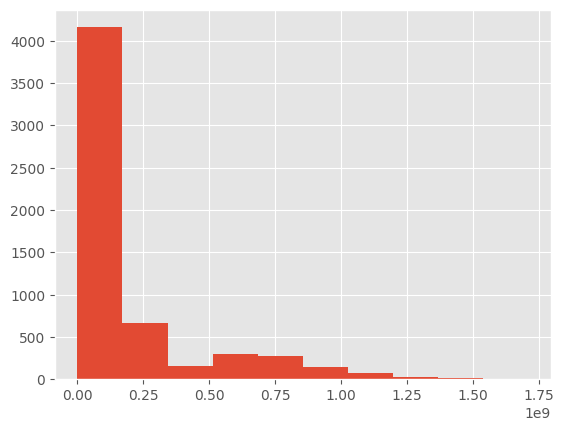

In [ ]:
# Distribution of Various Features
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df['Volume'].hist(bins = 10)

## Train model

In [ ]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_2(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Evaluate Model

In [ ]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

## Plot chart

In [ ]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## Model building

In [ ]:
# Extracting the series
series = df[['Close', 'High', 'Low']] # Picking the multivariate series
print(series.shape)
series

(5794, 3)


,Close,High,Low
Date,,,
2000-07-28,100.00,100.00,100.00
2000-07-28,100.00,100.00,100.00
2000-07-31,101.55,101.55,101.55
2000-08-02,103.38,103.38,103.38
2000-08-04,105.20,105.20,105.20
...,...,...,...
2024-05-23,1281.03,1281.03,1262.29
2024-05-24,1261.93,1285.07,1250.28
2024-05-27,1267.68,1267.68,1257.27


In [ ]:
# Train Val Test Split
train_start = dt.date(2000, 7, 28)                                     #train để huấn luyện mô hình
train_end = dt.date(2016, 5, 27)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2016, 5, 28)                                       #val để điều chỉnh siêu tham số và tránh overfitting
val_end = dt.date(2020, 5, 28)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2020, 5,29 )                                      #test để đánh giá hiệu suất
test_end = dt.date(2024, 5, 29)
test_data = series.loc[test_start:test_end]

print(train_data.shape, val_data.shape, test_data.shape)

(3786, 3) (1004, 3) (1004, 3)


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3786, 3) (1004, 3) (1004, 3)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 97: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 97: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 169: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 169: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 213: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 154: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 154: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 199: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 199: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 115: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 115: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 150: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 150: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 217: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Best Parameters: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}
Best RMSE Score: 0.020065215030383637
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.008871  0.094184   
1          30  [40, 35]  0.0010          32         250  0.008871  0.094184   
2          30  [40, 35]  0.0010          64         200  0.001084  0.032929   
3          30  [40, 35]  0.0010          64         250  0.001084  0.032929   
4          30  [40, 35]  0.0001          32         200  0.007211  0.084920   
5          30  [40, 35]  0.0001          32         250  0.000580  0.024088   
6          30  [40, 35]  0.0001          64         200  0.001529  0.039100   
7          30  [40, 35]  0.0001          64         250  0.000494  0.022221   
8          40  [40, 35]  0.0010          32         200  0.009397  0.096936   
9          40  [40, 35]  0.0010          32         250  0.009397  0.0

In [ ]:
timesteps =50
hl = [40,35]
lr = 1e-4
batch_size = 32
num_epochs = 250

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 217: early stopping


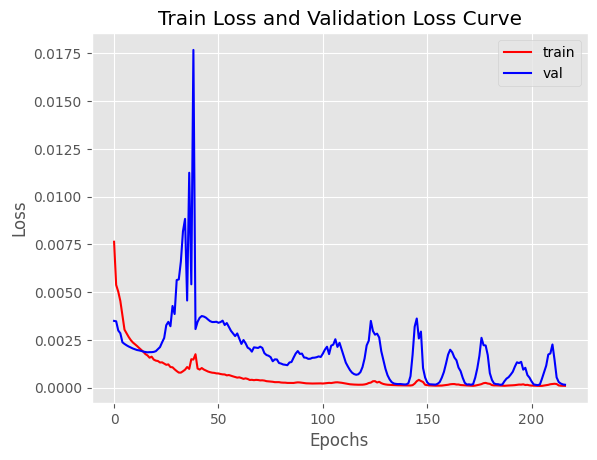

In [ ]:
model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.0004026128542155335
RMSE = 0.020065215030383637
MAPE = 0.014125504696375982
R-Squared Score = 0.9825533388691662


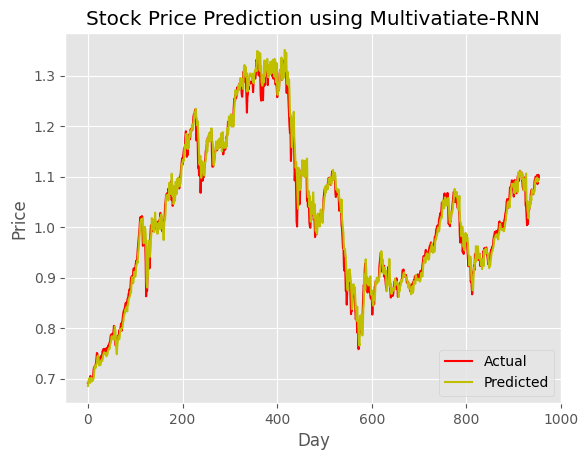

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_2(true, predicted)

In [ ]:
# Save a model
model.save('MV3-RNN_30_[50,45]_1e-3_32.h5')
del model

# Model 2: Multivariate-3-GRU


In [ ]:
import sys
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

##Data preprocessing

In [ ]:
url = 'vnindex.csv'
df = pd.read_csv(url, parse_dates = True, index_col = 0)

In [ ]:
df.corr()['Close']

,Close
Open,0.999743
High,0.999847
Low,0.999879
Close,1.000000
Volume,0.780469


In [ ]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    5.796000e+03
mean     1.796296e+08
std      2.720417e+08
min      0.000000e+00
25%      3.509555e+06
50%      6.246424e+07
75%      1.905016e+08
max      1.708781e+09
Name: Volume, dtype: float64


##Train Model


In [ ]:
def fit_model_3(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

##Evaluate Model


In [ ]:
def evaluate_model_3(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart


In [ ]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building


In [ ]:
series = df[['Close','High','Low']] # Picking the features
print(series.shape)

(5794, 3)


In [ ]:
# Train Val Test Split
train_start = dt.date(2000, 7, 28)                                     #train để huấn luyện mô hình
train_end = dt.date(2016, 5, 27)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2016, 5, 28)                                       #val để điều chỉnh siêu tham số và tránh overfitting
val_end = dt.date(2020, 5, 28)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2020, 5,29 )                                      #test để đánh giá hiệu suất
test_end = dt.date(2024, 5, 29)
test_data = series.loc[test_start:test_end]

print(train_data.shape, val_data.shape, test_data.shape)

(3786, 3) (1004, 3) (1004, 3)


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3786, 3) (1004, 3) (1004, 3)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 85: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 85: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 127: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 127: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 90: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 90: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 220: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 166: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 166: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 135: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 135: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 90: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 90: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 172: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 172: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 86: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 86: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 134: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 134: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 218: early stopping
Best Parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}
Best RMSE Score: 0.015949001460272266
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.006241  0.078998   
1          30  [40, 35]  0.0010          32         250  0.006241  0.078998   
2          30  [40, 35]  0.0010          64         200  0.000254  0.015949   
3          30  [40, 35]  0.0010          64         250  0.000254  0.015949   
4          30  [40, 35]  0.0001          32         200  0.001833  0.042819   
5          30  [40, 35]  0.0001          32         250  0.001833  0.042819   
6          30  [40, 35]  0.0001          64         200  0.000445  0.021086   
7          30  [40, 35]  0.0001          64         250  0.000491  0.022155   
8          40  [40, 35]  0.0010          32         200  0.003400  0.058309   
9          40  [40, 35]  0.0010          32  

In [ ]:
timesteps = 30
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 127: early stopping


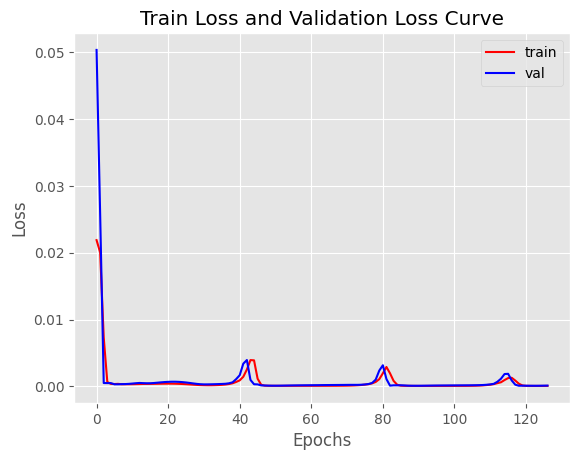

In [ ]:
model, train_error, val_error = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.00025437064757976685
RMSE = 0.015949001460272266
MAPE = 0.011981832448275862
R-Squared Score = 0.989746299575059


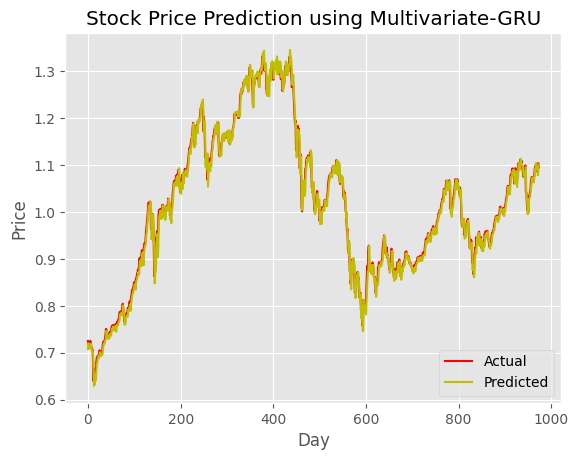

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_3(true, predicted)

In [ ]:
# Save a model
model.save('MV3-GRU_40_[40,35]_1e-4_64.h5')
del model  #Deletes the model

# Model 3: Multivariate-3-LSTM


In [ ]:
import sys
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [ ]:
# Loading the dataset
url = 'vnindex.csv'
df = pd.read_csv(url,parse_dates = True , index_col = 0)

In [ ]:
# Correlation matrix
df.corr()['Close']

,Close
Open,0.999743
High,0.999847
Low,0.999879
Close,1.000000
Volume,0.780469


In [ ]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    5.796000e+03
mean     1.796296e+08
std      2.720417e+08
min      0.000000e+00
25%      3.509555e+06
50%      6.246424e+07
75%      1.905016e+08
max      1.708781e+09
Name: Volume, dtype: float64


## Train Model


In [ ]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation = 'relu', return_sequences = True))
    model.add(LSTM(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

## Evaluate Model

In [ ]:
def evaluate_model_4(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


##Plot chart

In [ ]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building

In [ ]:
series = df[['Close','High','Low']] # Picking the features
print(series.shape)

(5794, 3)


In [ ]:
# Train Val Test Split
train_start = dt.date(2000, 7, 28)                                     #train để huấn luyện mô hình
train_end = dt.date(2016, 5, 27)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2016, 5, 28)                                       #val để điều chỉnh siêu tham số và tránh overfitting
val_end = dt.date(2020, 5, 28)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2020, 5,29 )                                      #test để đánh giá hiệu suất
test_end = dt.date(2024, 5, 29)
test_data = series.loc[test_start:test_end]

print(train_data.shape, val_data.shape, test_data.shape)

(3786, 3) (1004, 3) (1004, 3)


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(3786, 3) (1004, 3) (1004, 3)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 84: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 84: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 166: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 166: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 92: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 92: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 86: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 86: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 242: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 108: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 108: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 206: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 92: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 92: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Best Parameters: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}
Best RMSE Score: 0.023370856886123254
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.007634  0.087373   
1          30  [40, 35]  0.0010          32         250  0.007634  0.087373   
2          30  [40, 35]  0.0010          64         200  0.003911  0.062541   
3          30  [40, 35]  0.0010          64         250  0.003911  0.062541   
4          30  [40, 35]  0.0001          32         200  0.008307  0.091141   
5          30  [40, 35]  0.0001          32         250  0.008307  0.091141   
6          30  [40, 35]  0.0001          64         200  0.008272  0.090953   
7          30  [40, 35]  0.0001          64         250  0.004847  0.069620   
8          40  [40, 35]  0.0010          32         200  0.011101  0.105361   
9          40  [40, 35]  0.0010          32         250  0.011101  0.10

In [ ]:
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 250

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 206: early stopping


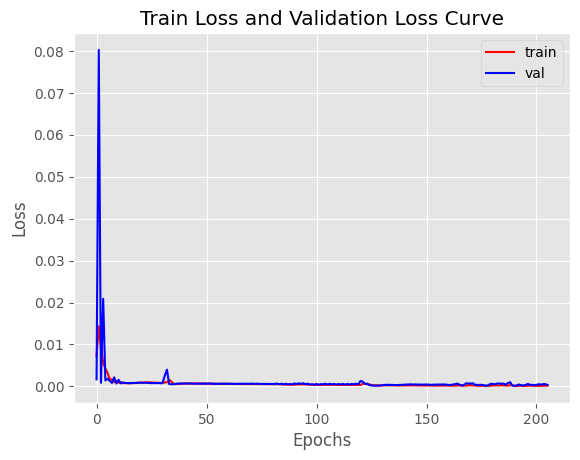

In [ ]:
model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.0005461969515916546
RMSE = 0.023370856886123254
MAPE = 0.017889659122252478
R-Squared Score = 0.9763313241856589


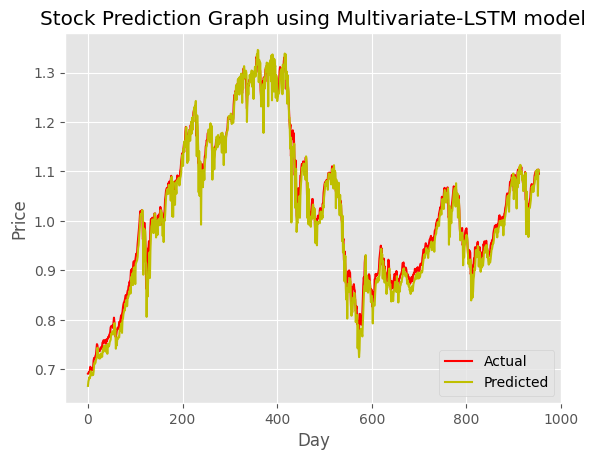

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_4(true, predicted)

In [ ]:
# Save a model
model.save('MV3-LSTM_50_[40,35]_1e-3_64.h5')
del model # Deletes the model